In [1]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from sklearn.metrics import mean_squared_error, mean_absolute_error

import warnings
warnings.filterwarnings('ignore')

In [2]:
SIE = pd.read_csv("data/siemens.csv")
DTE = pd.read_csv("data/deutsche-telekom.csv")
ALV = pd.read_csv("data/allianz.csv")
MRK = pd.read_csv("data/merck-kgaa.csv")
DHL = pd.read_csv("data/deutsche-post.csv")

In [3]:
# Change Dtype of Date column
SIE["Date"] = pd.to_datetime(SIE["Date"])
DTE["Date"] = pd.to_datetime(DTE["Date"])
ALV["Date"] = pd.to_datetime(ALV["Date"])
MRK["Date"] = pd.to_datetime(MRK["Date"])
DHL["Date"] = pd.to_datetime(DHL["Date"])

In [4]:
SIE.set_index('Date', inplace=True)
DTE.set_index('Date', inplace=True)
ALV.set_index('Date', inplace=True)
MRK.set_index('Date', inplace=True)
DHL.set_index('Date', inplace=True)

In [5]:
# Set date variable
start_date = '2010-01-04' # Start date of training set
end_date = '2020-09-30' # End date of training set
test_start_date = '2020-10-01' # End date of test set
test_end_date = '2023-06-30' # End date of test set

In [6]:
# Define a function to split data to train set and test set
def split(df, end_date, test_start_date):
    train = df.loc[:end_date]
    test = df.loc[test_start_date:]
    return train, test

In [7]:
# Define a function to split data to train set and validation set
def split_val(data, rate):
    idx = int(len(data) * rate)
    train = data[:idx]
    val = data[idx:]
    return train, val

In [8]:
# Define a function to process data (Mehtab et al., 2021)
def Dataset(Data, number_features):

    Train_Data = Data.to_numpy()
    Data_Train = []
    Data_Train_X = []
    Data_Train_Y = []
    for i in range(0, len(Train_Data), 5):
        if len(Train_Data[i : i + 5]) == 5:
            Data_Train.append(Train_Data[i : i + 5])

    if len(Data_Train[-1]) < 5:
        Data_Train.pop(-1)

    Data_Train_X = Data_Train[0 : -1]
    Data_Train_X = np.array(Data_Train_X)
    Data_Train_X = Data_Train_X.reshape((-1, 5, number_features))
    
    Train_Label = Data['Close'].to_numpy()
    for i in range(0, len(Train_Label), 5):
        if len(Train_Label[i : i + 5]) == 5:
            Data_Train_Y.append(Train_Label[i : i + 5])
    
    if len(Data_Train_Y[-1]) < 5:
        Data_Train_Y.pop(-1)
    Data_Train_Y = Data_Train_Y[1 : len(Data_Train_Y)]
    Data_Train_Y = np.array(Data_Train_Y)
    Data_Train_Y = Data_Train_Y.reshape((-1, 5, 1))
    
    return Data_Train_X, Data_Train_Y

In [9]:
def scheduler(epoch):
    if epoch <= 150:
        lrate = (10 ** -5) * (epoch / 150) 
    elif epoch <= 400:
        initial_lrate = (10 ** -5)
        k = 0.01
        lrate = initial_lrate * math.exp(-k * (epoch - 150))
    else:
        lrate = (10 ** -6)
    return lrate

# 1. Features = {price, p/e ratio}

## 1.1. SIE

In [10]:
SIE

,Open,High,Low,Close,Volume,Dividends,Stock Splits,pe-ratio,ps-ratio,pb-ratio,Ticker
Date,,,,,,,,,,,
2010-01-04,39.453722,39.898530,39.362323,39.892437,2734897.0,0.0,0.0,21.092000,0.762592,1.938798,siemens
2010-01-05,39.849782,40.148349,39.593865,39.916805,2584717.0,0.0,0.0,21.092000,0.762592,1.938798,siemens
2010-01-06,39.880244,40.130068,39.752286,40.063042,2166413.0,0.0,0.0,21.092000,0.762592,1.938798,siemens
2010-01-07,40.032576,40.702835,39.709636,40.538315,3336865.0,0.0,0.0,21.092000,0.762592,1.938798,siemens
2010-01-08,40.733299,40.964843,40.325055,40.794235,2634386.0,0.0,0.0,21.092000,0.762592,1.938798,siemens
...,...,...,...,...,...,...,...,...,...,...,...
2023-06-26,157.399994,157.699997,155.320007,155.479996,1312767.0,0.0,0.0,19.691292,1.515738,1.998793,siemens
2023-06-27,156.399994,158.039993,155.979996,157.559998,1065494.0,0.0,0.0,19.691292,1.515738,1.998793,siemens
2023-06-28,158.940002,159.639999,150.399994,152.720001,2094689.0,0.0,0.0,19.691292,1.515738,1.998793,siemens


In [11]:
SIE.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3449 entries, 2010-01-04 to 2023-06-30
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Open          3449 non-null   float64
 1   High          3449 non-null   float64
 2   Low           3449 non-null   float64
 3   Close         3449 non-null   float64
 4   Volume        3449 non-null   float64
 5   Dividends     3449 non-null   float64
 6   Stock Splits  3449 non-null   float64
 7   pe-ratio      3449 non-null   float64
 8   ps-ratio      3449 non-null   float64
 9   pb-ratio      3449 non-null   float64
 10  Ticker        3449 non-null   object 
dtypes: float64(10), object(1)
memory usage: 323.3+ KB


In [12]:
SIE_df1 = SIE[["Close", "pe-ratio"]]
SIE_df1

,Close,pe-ratio
Date,,
2010-01-04,39.892437,21.092000
2010-01-05,39.916805,21.092000
2010-01-06,40.063042,21.092000
2010-01-07,40.538315,21.092000
2010-01-08,40.794235,21.092000
...,...,...
2023-06-26,155.479996,19.691292
2023-06-27,157.559998,19.691292
2023-06-28,152.720001,19.691292


### Data Proprocessing

In [13]:
# Split data to train set and test set
train, test = split(SIE_df1, end_date, test_start_date)

In [14]:
# Reconcile length of data set and subsets
SIE_df1.shape[0] == train.shape[0] + test.shape[0]

True

In [15]:
# Process data
X_train, y_train = Dataset(train, 2)
X_test, y_test = Dataset(test, 2)

In [16]:
# Split train set to train set and validation set
X_train, X_val = split_val(X_train, 0.8)
y_train, y_val = split_val(y_train, 0.8)

### Model

In [17]:
# Define model (Mehtab et al., 2021)
def Model():
    model = tf.keras.models.Sequential([
                                      tf.keras.layers.LSTM(200, input_shape = (5, 2), activation = tf.nn.leaky_relu, return_sequences = True),
                                      tf.keras.layers.LSTM(200, activation = tf.nn.leaky_relu),
                                      tf.keras.layers.Dense(200, activation = tf.nn.leaky_relu),
                                      tf.keras.layers.Dense(100, activation = tf.nn.leaky_relu),
                                      tf.keras.layers.Dense(50, activation = tf.nn.leaky_relu),
                                      tf.keras.layers.Dense(5, activation = tf.nn.leaky_relu)
                                      ])
    return model

In [18]:
model = Model()

In [19]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 5, 200)            162400    
                                                                 
 lstm_1 (LSTM)               (None, 200)               320800    
                                                                 
 dense (Dense)               (None, 200)               40200     
                                                                 
 dense_1 (Dense)             (None, 100)               20100     
                                                                 
 dense_2 (Dense)             (None, 50)                5050      
                                                                 
 dense_3 (Dense)             (None, 5)                 255       
                                                                 
Total params: 548,805
Trainable params: 548,805
Non-trai

### Custom Learning Rate

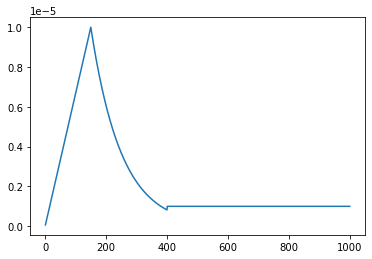

In [20]:
epochs = [i for i in range(1, 1001, 1)]
lrate = [scheduler(i) for i in range(1, 1001, 1)]
plt.plot(epochs, lrate)

In [21]:
callback = tf.keras.callbacks.LearningRateScheduler(scheduler)

### Learning

In [22]:
# Compile model (Mehtab et al., 2021)
model.compile(optimizer = tf.keras.optimizers.Adam(), loss = 'mse', metrics = tf.keras.metrics.RootMeanSquaredError())

In [23]:
# Fit model (Mehtab et al., 2021)
hist = model.fit(X_train, y_train, epochs = 200, validation_data = (X_val, y_val), callbacks=[callback])

Epoch 1/200
14/14 [==============================] - 4s 66ms/step - loss: 4956.6460 - root_mean_squared_error: 70.4035 - val_loss: 8260.6650 - val_root_mean_squared_error: 90.8882 - lr: 0.0000e+00
Epoch 2/200
14/14 [==============================] - 0s 21ms/step - loss: 4956.5640 - root_mean_squared_error: 70.4029 - val_loss: 8260.3730 - val_root_mean_squared_error: 90.8866 - lr: 6.6667e-08
Epoch 3/200
14/14 [==============================] - 0s 24ms/step - loss: 4956.2993 - root_mean_squared_error: 70.4010 - val_loss: 8259.7900 - val_root_mean_squared_error: 90.8834 - lr: 1.3333e-07
Epoch 4/200
14/14 [==============================] - 0s 26ms/step - loss: 4955.8584 - root_mean_squared_error: 70.3979 - val_loss: 8258.9033 - val_root_mean_squared_error: 90.8785 - lr: 2.0000e-07
Epoch 5/200
14/14 [==============================] - 0s 24ms/step - loss: 4955.2334 - root_mean_squared_error: 70.3934 - val_loss: 8257.7090 - val_root_mean_squared_error: 90.8719 - lr: 2.6667e-07
Epoch 6/200
14/

14/14 [==============================] - 0s 26ms/step - loss: 742.8275 - root_mean_squared_error: 27.2549 - val_loss: 1140.8027 - val_root_mean_squared_error: 33.7758 - lr: 5.4667e-06
Epoch 84/200
14/14 [==============================] - 0s 26ms/step - loss: 631.2077 - root_mean_squared_error: 25.1238 - val_loss: 950.0982 - val_root_mean_squared_error: 30.8237 - lr: 5.5333e-06
Epoch 85/200
14/14 [==============================] - 0s 27ms/step - loss: 515.9371 - root_mean_squared_error: 22.7142 - val_loss: 768.3025 - val_root_mean_squared_error: 27.7183 - lr: 5.6000e-06
Epoch 86/200
14/14 [==============================] - 0s 28ms/step - loss: 412.8927 - root_mean_squared_error: 20.3198 - val_loss: 610.8065 - val_root_mean_squared_error: 24.7145 - lr: 5.6667e-06
Epoch 87/200
14/14 [==============================] - 0s 28ms/step - loss: 323.4837 - root_mean_squared_error: 17.9857 - val_loss: 468.2132 - val_root_mean_squared_error: 21.6382 - lr: 5.7333e-06
Epoch 88/200
14/14 [============

Epoch 168/200
14/14 [==============================] - 0s 27ms/step - loss: 5.1545 - root_mean_squared_error: 2.2703 - val_loss: 15.0050 - val_root_mean_squared_error: 3.8736 - lr: 8.4366e-06
Epoch 169/200
14/14 [==============================] - 0s 26ms/step - loss: 5.0994 - root_mean_squared_error: 2.2582 - val_loss: 14.9726 - val_root_mean_squared_error: 3.8694 - lr: 8.3527e-06
Epoch 170/200
14/14 [==============================] - 0s 27ms/step - loss: 5.0826 - root_mean_squared_error: 2.2545 - val_loss: 14.9026 - val_root_mean_squared_error: 3.8604 - lr: 8.2696e-06
Epoch 171/200
14/14 [==============================] - 0s 28ms/step - loss: 5.0593 - root_mean_squared_error: 2.2493 - val_loss: 14.8672 - val_root_mean_squared_error: 3.8558 - lr: 8.1873e-06
Epoch 172/200
14/14 [==============================] - 0s 26ms/step - loss: 5.0436 - root_mean_squared_error: 2.2458 - val_loss: 14.8113 - val_root_mean_squared_error: 3.8485 - lr: 8.1058e-06
Epoch 173/200
14/14 [===================

In [24]:
history_dict = hist.history

loss = history_dict["loss"]
root_mean_squared_error = history_dict["root_mean_squared_error"]
val_loss = history_dict["val_loss"]
val_root_mean_squared_error = history_dict["val_root_mean_squared_error"]

epochs = range(1, len(loss) + 1)

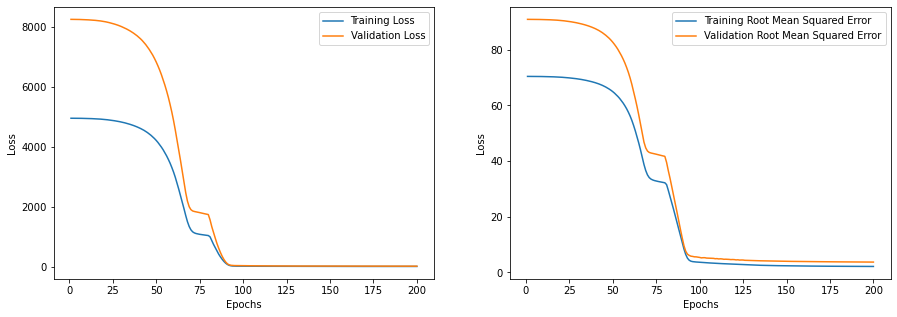

In [25]:
fig, (ax1, ax2) = plt.subplots(1, 2)

fig.set_figheight(5)
fig.set_figwidth(15)

ax1.plot(epochs, loss, label = 'Training Loss')
ax1.plot(epochs, val_loss, label = 'Validation Loss')
ax1.set(xlabel = "Epochs", ylabel = "Loss")
ax1.legend()

ax2.plot(epochs, root_mean_squared_error, label = "Training Root Mean Squared Error")
ax2.plot(epochs, val_root_mean_squared_error, label = "Validation Root Mean Squared Error")
ax2.set(xlabel = "Epochs", ylabel = "Loss")
ax2.legend()

plt.show()

### Prediction

In [26]:
prediction = model.predict(X_test)

5/5 [==============================] - 0s 9ms/step


In [27]:
len(prediction.reshape(-1))

695

In [28]:
temp1 = test.tail(695)

In [29]:
temp1['Forecast'] = prediction.reshape(-1)

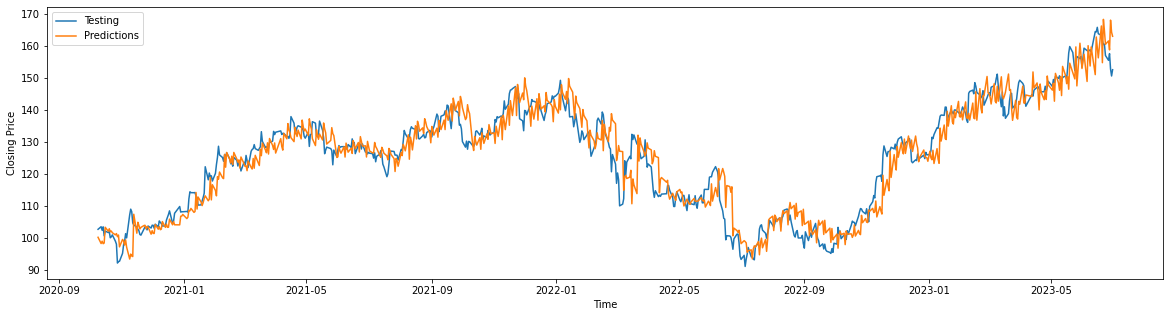

In [30]:
plt.figure(figsize=(20, 5))
plt.plot(temp1['Close'], label = 'Testing')
plt.plot(temp1['Forecast'], label = 'Predictions')
plt.xlabel('Time')
plt.ylabel('Closing Price')
plt.legend(loc = 'best')

In [31]:
rmse = math.sqrt(mean_squared_error(y_test.reshape(-1, 5), prediction))
mape = np.mean(np.abs(prediction - y_test.reshape(-1, 5))/np.abs(y_test.reshape(-1, 5)))
print(f'RMSE: {rmse}')
print(f'MAPE: {mape}')

RMSE: 4.978743367470495
MAPE: 0.030259214833386224


In [32]:
temp1

,Close,pe-ratio,Forecast
Date,,,
2020-10-09,102.678017,21.575999,100.183418
2020-10-12,103.487961,21.575999,98.232193
2020-10-13,102.383484,21.575999,98.965065
2020-10-14,103.451141,21.575999,98.185829
2020-10-15,100.634758,21.575999,98.383385
...,...,...,...
2023-06-26,155.479996,19.691292,161.531769
2023-06-27,157.559998,19.691292,158.733322
2023-06-28,152.720001,19.691292,168.029846


In [33]:
# Create a dataframe that has same index as SIE dataframe
result1 = pd.DataFrame(index=SIE.index)
# Extract actual data from SIE
tem1 = SIE['Close'].tolist()[:len(SIE)-695]
# Extract forecasted date from above result
tem2 = temp1['Forecast'].tolist()
# Combine them to a list
tem3 = tem1 + tem2
# Create a column from the resulted list
result1['SIE'] = tem3
# Mark forecasted or not for each line
result1['Forecasted'] = 'N'
result1.loc[result1.index[-695:], 'Forecasted'] = 'Y'

In [34]:
result1

,SIE,Forecasted
Date,,
2010-01-04,39.892437,N
2010-01-05,39.916805,N
2010-01-06,40.063042,N
2010-01-07,40.538315,N
2010-01-08,40.794235,N
...,...,...
2023-06-26,161.531769,Y
2023-06-27,158.733322,Y
2023-06-28,168.029846,Y


## 1.2. DTE

In [35]:
DTE

,Open,High,Low,Close,Volume,Dividends,Stock Splits,pe-ratio,ps-ratio,pb-ratio,Ticker
Date,,,,,,,,,,,
2010-01-04,4.826971,4.953136,4.817626,4.953136,14257860.0,0.0,0.0,128.625000,0.707311,1.070129,deutsche-telekom
2010-01-05,4.948465,4.953138,4.871364,4.911083,14077418.0,0.0,0.0,128.625000,0.707311,1.070129,deutsche-telekom
2010-01-06,4.831645,4.833982,4.770899,4.789590,28100490.0,0.0,0.0,128.625000,0.707311,1.070129,deutsche-telekom
2010-01-07,4.766226,4.770899,4.663425,4.698472,21799244.0,0.0,0.0,128.625000,0.707311,1.070129,deutsche-telekom
2010-01-08,4.707817,4.728844,4.668565,4.724171,20945576.0,0.0,0.0,128.625000,0.707311,1.070129,deutsche-telekom
...,...,...,...,...,...,...,...,...,...,...,...
2023-06-26,19.528000,19.733999,19.493999,19.695999,6407184.0,0.0,0.0,5.658228,1.014428,1.057418,deutsche-telekom
2023-06-27,19.830000,19.968000,19.712000,19.906000,0.0,0.0,0.0,5.658228,1.014428,1.057418,deutsche-telekom
2023-06-28,20.000000,20.155001,19.927999,20.030001,8299496.0,0.0,0.0,5.658228,1.014428,1.057418,deutsche-telekom


In [36]:
DTE.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3449 entries, 2010-01-04 to 2023-06-30
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Open          3449 non-null   float64
 1   High          3449 non-null   float64
 2   Low           3449 non-null   float64
 3   Close         3449 non-null   float64
 4   Volume        3449 non-null   float64
 5   Dividends     3449 non-null   float64
 6   Stock Splits  3449 non-null   float64
 7   pe-ratio      3449 non-null   float64
 8   ps-ratio      3449 non-null   float64
 9   pb-ratio      3449 non-null   float64
 10  Ticker        3449 non-null   object 
dtypes: float64(10), object(1)
memory usage: 323.3+ KB


In [37]:
DTE_df1 = DTE[["Close" , "pe-ratio"]]
DTE_df1

,Close,pe-ratio
Date,,
2010-01-04,4.953136,128.625000
2010-01-05,4.911083,128.625000
2010-01-06,4.789590,128.625000
2010-01-07,4.698472,128.625000
2010-01-08,4.724171,128.625000
...,...,...
2023-06-26,19.695999,5.658228
2023-06-27,19.906000,5.658228
2023-06-28,20.030001,5.658228


### Data Proprocessing

In [38]:
# Split data to train set and test set
train, test = split(DTE_df1, end_date, test_start_date)

In [39]:
# Reconcile length of data set and subsets
DTE_df1.shape[0] == train.shape[0] + test.shape[0]

True

In [40]:
# Process data
X_train, y_train = Dataset(train, 2)
X_test, y_test = Dataset(test, 2)

In [41]:
# Split train set to train set and validation set
X_train, X_val = split_val(X_train, 0.8)
y_train, y_val = split_val(y_train, 0.8)

### Model

In [42]:
# Define model (Mehtab et al., 2021)
def Model():
    model = tf.keras.models.Sequential([
                                      tf.keras.layers.LSTM(200, input_shape = (5, 2), activation = tf.nn.leaky_relu, return_sequences = True),
                                      tf.keras.layers.LSTM(200, activation = tf.nn.leaky_relu, return_sequences = True),
                                      tf.keras.layers.LSTM(200, activation = tf.nn.leaky_relu),
                                      tf.keras.layers.Dense(300, activation = tf.nn.leaky_relu),
                                      tf.keras.layers.Dense(200, activation = tf.nn.leaky_relu),
                                      tf.keras.layers.Dense(100, activation = tf.nn.leaky_relu),
                                      tf.keras.layers.Dense(50, activation = tf.nn.leaky_relu),
                                      tf.keras.layers.Dense(5, activation = tf.nn.leaky_relu)
                                      ])
    return model

In [43]:
model = Model()

In [44]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 5, 200)            162400    
                                                                 
 lstm_3 (LSTM)               (None, 5, 200)            320800    
                                                                 
 lstm_4 (LSTM)               (None, 200)               320800    
                                                                 
 dense_4 (Dense)             (None, 300)               60300     
                                                                 
 dense_5 (Dense)             (None, 200)               60200     
                                                                 
 dense_6 (Dense)             (None, 100)               20100     
                                                                 
 dense_7 (Dense)             (None, 50)               

### Custom Learning Rate

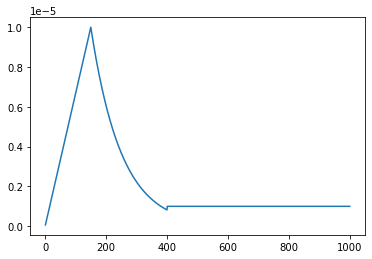

In [45]:
epochs = [i for i in range(1, 1001, 1)]
lrate = [scheduler(i) for i in range(1, 1001, 1)]
plt.plot(epochs, lrate)

In [46]:
callback = tf.keras.callbacks.LearningRateScheduler(scheduler)

### Learning

In [47]:
# Compile model (Mehtab et al., 2021)
model.compile(optimizer = tf.keras.optimizers.Adam(), loss = 'mse', metrics = tf.keras.metrics.RootMeanSquaredError())

In [48]:
# Fit model (Mehtab et al., 2021)
hist = model.fit(X_train, y_train, epochs = 200, validation_data = (X_val, y_val), callbacks=[callback])

Epoch 1/200
14/14 [==============================] - 6s 75ms/step - loss: 69.9137 - root_mean_squared_error: 8.3614 - val_loss: 147.4868 - val_root_mean_squared_error: 12.1444 - lr: 0.0000e+00
Epoch 2/200
14/14 [==============================] - 0s 30ms/step - loss: 69.9126 - root_mean_squared_error: 8.3614 - val_loss: 147.4855 - val_root_mean_squared_error: 12.1444 - lr: 6.6667e-08
Epoch 3/200
14/14 [==============================] - 0s 31ms/step - loss: 69.9091 - root_mean_squared_error: 8.3612 - val_loss: 147.4829 - val_root_mean_squared_error: 12.1443 - lr: 1.3333e-07
Epoch 4/200
14/14 [==============================] - 0s 29ms/step - loss: 69.9030 - root_mean_squared_error: 8.3608 - val_loss: 147.4789 - val_root_mean_squared_error: 12.1441 - lr: 2.0000e-07
Epoch 5/200
14/14 [==============================] - 0s 31ms/step - loss: 69.8946 - root_mean_squared_error: 8.3603 - val_loss: 147.4738 - val_root_mean_squared_error: 12.1439 - lr: 2.6667e-07
Epoch 6/200
14/14 [================

14/14 [==============================] - 0s 34ms/step - loss: 7.7460 - root_mean_squared_error: 2.7832 - val_loss: 4.6852 - val_root_mean_squared_error: 2.1645 - lr: 5.6000e-06
Epoch 86/200
14/14 [==============================] - 1s 37ms/step - loss: 7.3695 - root_mean_squared_error: 2.7147 - val_loss: 3.7242 - val_root_mean_squared_error: 1.9298 - lr: 5.6667e-06
Epoch 87/200
14/14 [==============================] - 1s 37ms/step - loss: 7.0534 - root_mean_squared_error: 2.6558 - val_loss: 3.3755 - val_root_mean_squared_error: 1.8372 - lr: 5.7333e-06
Epoch 88/200
14/14 [==============================] - 0s 35ms/step - loss: 6.7036 - root_mean_squared_error: 2.5891 - val_loss: 2.6243 - val_root_mean_squared_error: 1.6200 - lr: 5.8000e-06
Epoch 89/200
14/14 [==============================] - 0s 35ms/step - loss: 6.4417 - root_mean_squared_error: 2.5381 - val_loss: 2.2221 - val_root_mean_squared_error: 1.4907 - lr: 5.8667e-06
Epoch 90/200
14/14 [==============================] - 0s 32ms/s

14/14 [==============================] - 1s 37ms/step - loss: 0.3687 - root_mean_squared_error: 0.6072 - val_loss: 1.8527 - val_root_mean_squared_error: 1.3611 - lr: 8.4667e-06
Epoch 129/200
14/14 [==============================] - 0s 34ms/step - loss: 0.3508 - root_mean_squared_error: 0.5922 - val_loss: 1.6876 - val_root_mean_squared_error: 1.2991 - lr: 8.5333e-06
Epoch 130/200
14/14 [==============================] - 1s 39ms/step - loss: 0.3360 - root_mean_squared_error: 0.5796 - val_loss: 1.7638 - val_root_mean_squared_error: 1.3281 - lr: 8.6000e-06
Epoch 131/200
14/14 [==============================] - 1s 39ms/step - loss: 0.3241 - root_mean_squared_error: 0.5693 - val_loss: 1.7286 - val_root_mean_squared_error: 1.3148 - lr: 8.6667e-06
Epoch 132/200
14/14 [==============================] - 1s 41ms/step - loss: 0.3163 - root_mean_squared_error: 0.5624 - val_loss: 1.5489 - val_root_mean_squared_error: 1.2445 - lr: 8.7333e-06
Epoch 133/200
14/14 [==============================] - 0s 3

Epoch 171/200
14/14 [==============================] - 1s 37ms/step - loss: 0.2014 - root_mean_squared_error: 0.4488 - val_loss: 0.8144 - val_root_mean_squared_error: 0.9024 - lr: 8.1873e-06
Epoch 172/200
14/14 [==============================] - 1s 37ms/step - loss: 0.2016 - root_mean_squared_error: 0.4490 - val_loss: 0.9015 - val_root_mean_squared_error: 0.9495 - lr: 8.1058e-06
Epoch 173/200
14/14 [==============================] - 1s 36ms/step - loss: 0.1982 - root_mean_squared_error: 0.4452 - val_loss: 0.8309 - val_root_mean_squared_error: 0.9115 - lr: 8.0252e-06
Epoch 174/200
14/14 [==============================] - 1s 39ms/step - loss: 0.1993 - root_mean_squared_error: 0.4465 - val_loss: 0.8249 - val_root_mean_squared_error: 0.9082 - lr: 7.9453e-06
Epoch 175/200
14/14 [==============================] - 1s 36ms/step - loss: 0.1985 - root_mean_squared_error: 0.4456 - val_loss: 0.8006 - val_root_mean_squared_error: 0.8948 - lr: 7.8663e-06
Epoch 176/200
14/14 [========================

In [49]:
history_dict = hist.history

loss = history_dict["loss"]
root_mean_squared_error = history_dict["root_mean_squared_error"]
val_loss = history_dict["val_loss"]
val_root_mean_squared_error = history_dict["val_root_mean_squared_error"]

epochs = range(1, len(loss) + 1)

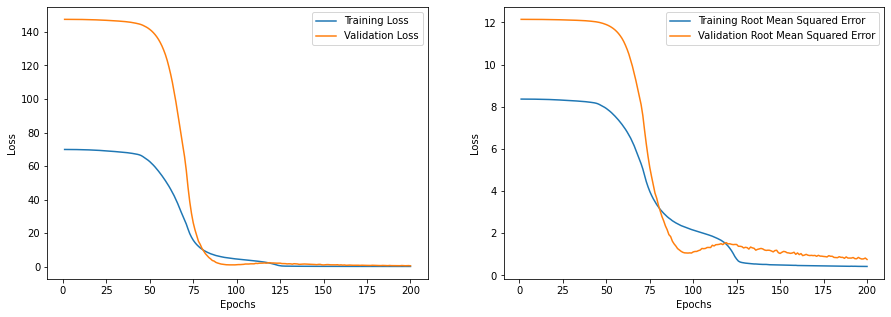

In [50]:
fig, (ax1, ax2) = plt.subplots(1, 2)

fig.set_figheight(5)
fig.set_figwidth(15)

ax1.plot(epochs, loss, label = 'Training Loss')
ax1.plot(epochs, val_loss, label = 'Validation Loss')
ax1.set(xlabel = "Epochs", ylabel = "Loss")
ax1.legend()

ax2.plot(epochs, root_mean_squared_error, label = "Training Root Mean Squared Error")
ax2.plot(epochs, val_root_mean_squared_error, label = "Validation Root Mean Squared Error")
ax2.set(xlabel = "Epochs", ylabel = "Loss")
ax2.legend()

plt.show()

### Prediction

In [51]:
prediction = model.predict(X_test)

5/5 [==============================] - 1s 13ms/step


In [52]:
len(prediction.reshape(-1))

695

In [53]:
temp1 = test.tail(695)

In [54]:
temp1['Forecast'] = prediction.reshape(-1)

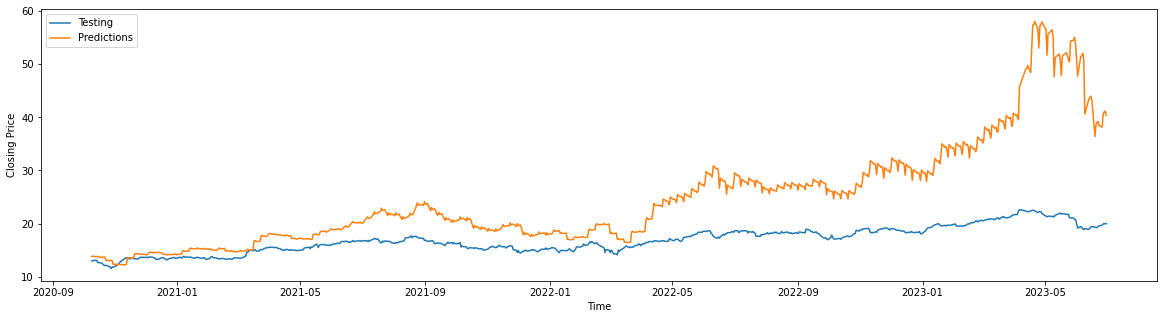

In [55]:
plt.figure(figsize=(20, 5))
plt.plot(temp1['Close'], label = 'Testing')
plt.plot(temp1['Forecast'], label = 'Predictions')
plt.xlabel('Time')
plt.ylabel('Closing Price')
plt.legend(loc = 'best')

In [56]:
rmse = math.sqrt(mean_squared_error(y_test.reshape(-1, 5), prediction))
mape = np.mean(np.abs(prediction - y_test.reshape(-1, 5))/np.abs(y_test.reshape(-1, 5)))
print(f'RMSE: {rmse}')
print(f'MAPE: {mape}')

RMSE: 10.907775836206136
MAPE: 0.4192162561809846


In [57]:
temp1

,Close,pe-ratio,Forecast
Date,,,
2020-10-09,12.981357,21.651515,13.822453
2020-10-12,13.067026,21.651515,13.852106
2020-10-13,13.107607,21.651515,13.725219
2020-10-14,13.053500,21.651515,13.819102
2020-10-15,12.643183,21.651515,13.809062
...,...,...,...
2023-06-26,19.695999,5.658228,38.137283
2023-06-27,19.906000,5.658228,40.614021
2023-06-28,20.030001,5.658228,40.979473


In [58]:
# Extract actual data from SIE
tem1 = DTE['Close'].tolist()[:len(DTE)-695]
# Extract forecasted date from above result
tem2 = temp1['Forecast'].tolist()
# Combine them to a list
tem3 = tem1 + tem2
# Create a column from the resulted list
result1['DTE'] = tem3

In [59]:
result1

,SIE,Forecasted,DTE
Date,,,
2010-01-04,39.892437,N,4.953136
2010-01-05,39.916805,N,4.911083
2010-01-06,40.063042,N,4.789590
2010-01-07,40.538315,N,4.698472
2010-01-08,40.794235,N,4.724171
...,...,...,...
2023-06-26,161.531769,Y,38.137283
2023-06-27,158.733322,Y,40.614021
2023-06-28,168.029846,Y,40.979473


## 1.3. ALV

In [60]:
ALV

,Open,High,Low,Close,Volume,Dividends,Stock Splits,pe-ratio,ps-ratio,pb-ratio,Ticker
Date,,,,,,,,,,,
2010-01-04,45.138680,45.699056,45.035857,45.519119,1676777.0,0.0,0.0,9.154412,0.706716,1.292624,allianz
2010-01-05,45.498549,46.110338,45.395729,45.657921,1742206.0,0.0,0.0,9.154412,0.706716,1.292624,allianz
2010-01-06,45.832728,46.161757,45.627084,46.012665,1362139.0,0.0,0.0,9.154412,0.706716,1.292624,allianz
2010-01-07,45.714478,45.981817,45.421437,45.483131,1926360.0,0.0,0.0,9.154412,0.706716,1.292624,allianz
2010-01-08,45.848145,45.848145,44.562875,45.236355,2425290.0,0.0,0.0,9.154412,0.706716,1.292624,allianz
...,...,...,...,...,...,...,...,...,...,...,...
2023-06-26,209.800003,209.800003,207.699997,209.199997,532054.0,0.0,0.0,10.264393,0.759921,1.461468,allianz
2023-06-27,210.149994,211.449997,209.649994,211.300003,640049.0,0.0,0.0,10.264393,0.759921,1.461468,allianz
2023-06-28,212.000000,212.800003,210.750000,211.649994,575057.0,0.0,0.0,10.264393,0.759921,1.461468,allianz


In [61]:
ALV.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3449 entries, 2010-01-04 to 2023-06-30
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Open          3449 non-null   float64
 1   High          3449 non-null   float64
 2   Low           3449 non-null   float64
 3   Close         3449 non-null   float64
 4   Volume        3449 non-null   float64
 5   Dividends     3449 non-null   float64
 6   Stock Splits  3449 non-null   float64
 7   pe-ratio      3449 non-null   float64
 8   ps-ratio      3449 non-null   float64
 9   pb-ratio      3449 non-null   float64
 10  Ticker        3449 non-null   object 
dtypes: float64(10), object(1)
memory usage: 323.3+ KB


In [62]:
ALV_df1 = ALV[["Close", "pe-ratio"]]
ALV_df1

,Close,pe-ratio
Date,,
2010-01-04,45.519119,9.154412
2010-01-05,45.657921,9.154412
2010-01-06,46.012665,9.154412
2010-01-07,45.483131,9.154412
2010-01-08,45.236355,9.154412
...,...,...
2023-06-26,209.199997,10.264393
2023-06-27,211.300003,10.264393
2023-06-28,211.649994,10.264393


### Data Proprocessing

In [63]:
# Split data to train set and test set
train, test = split(ALV_df1, end_date, test_start_date)

In [64]:
# Reconcile length of data set and subsets
ALV_df1.shape[0] == train.shape[0] + test.shape[0]

True

In [65]:
# Process data
X_train, y_train = Dataset(train, 2)
X_test, y_test = Dataset(test, 2)

In [66]:
# Split train set to train set and validation set
X_train, X_val = split_val(X_train, 0.8)
y_train, y_val = split_val(y_train, 0.8)

### Model

In [67]:
# Define model (Mehtab et al., 2021)
def Model():
    model = tf.keras.models.Sequential([
                                      tf.keras.layers.LSTM(200, input_shape = (5, 2), activation = tf.nn.leaky_relu, return_sequences = True),
                                      tf.keras.layers.LSTM(200, activation = tf.nn.leaky_relu),
                                      tf.keras.layers.Dense(200, activation = tf.nn.leaky_relu),
                                      tf.keras.layers.Dense(100, activation = tf.nn.leaky_relu),
                                      tf.keras.layers.Dense(50, activation = tf.nn.leaky_relu),
                                      tf.keras.layers.Dense(5, activation = tf.nn.leaky_relu)
                                      ])
    return model

In [68]:
model = Model()

In [69]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_5 (LSTM)               (None, 5, 200)            162400    
                                                                 
 lstm_6 (LSTM)               (None, 200)               320800    
                                                                 
 dense_9 (Dense)             (None, 200)               40200     
                                                                 
 dense_10 (Dense)            (None, 100)               20100     
                                                                 
 dense_11 (Dense)            (None, 50)                5050      
                                                                 
 dense_12 (Dense)            (None, 5)                 255       
                                                                 
Total params: 548,805
Trainable params: 548,805
Non-tr

### Custom Learning Rate

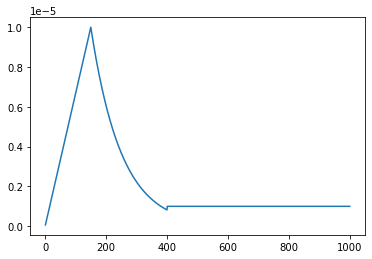

In [70]:
epochs = [i for i in range(1, 1001, 1)]
lrate = [scheduler(i) for i in range(1, 1001, 1)]
plt.plot(epochs, lrate)

In [71]:
callback = tf.keras.callbacks.LearningRateScheduler(scheduler)

### Learning

In [72]:
# Compile model (Mehtab et al., 2021)
model.compile(optimizer = tf.keras.optimizers.Adam(), loss = 'mse', metrics = tf.keras.metrics.RootMeanSquaredError())

In [73]:
# Fit model (Mehtab et al., 2021)
hist = model.fit(X_train, y_train, epochs = 200, validation_data = (X_val, y_val), callbacks=[callback])

Epoch 1/200
14/14 [==============================] - 5s 57ms/step - loss: 7907.5234 - root_mean_squared_error: 88.9243 - val_loss: 24707.9004 - val_root_mean_squared_error: 157.1875 - lr: 0.0000e+00
Epoch 2/200
14/14 [==============================] - 0s 23ms/step - loss: 7907.4360 - root_mean_squared_error: 88.9238 - val_loss: 24707.2969 - val_root_mean_squared_error: 157.1855 - lr: 6.6667e-08
Epoch 3/200
14/14 [==============================] - 0s 28ms/step - loss: 7907.1611 - root_mean_squared_error: 88.9222 - val_loss: 24706.0996 - val_root_mean_squared_error: 157.1817 - lr: 1.3333e-07
Epoch 4/200
14/14 [==============================] - 0s 29ms/step - loss: 7906.6982 - root_mean_squared_error: 88.9196 - val_loss: 24704.2832 - val_root_mean_squared_error: 157.1759 - lr: 2.0000e-07
Epoch 5/200
14/14 [==============================] - 0s 28ms/step - loss: 7906.0547 - root_mean_squared_error: 88.9160 - val_loss: 24701.8301 - val_root_mean_squared_error: 157.1682 - lr: 2.6667e-07
Epoch

14/14 [==============================] - 0s 29ms/step - loss: 7458.9263 - root_mean_squared_error: 86.3651 - val_loss: 22986.7695 - val_root_mean_squared_error: 151.6139 - lr: 2.7333e-06
Epoch 43/200
14/14 [==============================] - 0s 29ms/step - loss: 7397.8184 - root_mean_squared_error: 86.0106 - val_loss: 22763.8301 - val_root_mean_squared_error: 150.8769 - lr: 2.8000e-06
Epoch 44/200
14/14 [==============================] - 0s 27ms/step - loss: 7334.9253 - root_mean_squared_error: 85.6442 - val_loss: 22549.8633 - val_root_mean_squared_error: 150.1661 - lr: 2.8667e-06
Epoch 45/200
14/14 [==============================] - 0s 29ms/step - loss: 7272.7603 - root_mean_squared_error: 85.2805 - val_loss: 22335.9727 - val_root_mean_squared_error: 149.4522 - lr: 2.9333e-06
Epoch 46/200
14/14 [==============================] - 0s 28ms/step - loss: 7208.1519 - root_mean_squared_error: 84.9008 - val_loss: 22106.8516 - val_root_mean_squared_error: 148.6837 - lr: 3.0000e-06
Epoch 47/200


Epoch 126/200
14/14 [==============================] - 0s 30ms/step - loss: 8.1094 - root_mean_squared_error: 2.8477 - val_loss: 57.2823 - val_root_mean_squared_error: 7.5685 - lr: 8.3333e-06
Epoch 127/200
14/14 [==============================] - 0s 30ms/step - loss: 8.1053 - root_mean_squared_error: 2.8470 - val_loss: 57.6967 - val_root_mean_squared_error: 7.5958 - lr: 8.4000e-06
Epoch 128/200
14/14 [==============================] - 0s 28ms/step - loss: 8.0399 - root_mean_squared_error: 2.8355 - val_loss: 56.9402 - val_root_mean_squared_error: 7.5459 - lr: 8.4667e-06
Epoch 129/200
14/14 [==============================] - 0s 29ms/step - loss: 8.0226 - root_mean_squared_error: 2.8324 - val_loss: 57.0236 - val_root_mean_squared_error: 7.5514 - lr: 8.5333e-06
Epoch 130/200
14/14 [==============================] - 0s 26ms/step - loss: 8.0211 - root_mean_squared_error: 2.8322 - val_loss: 57.3499 - val_root_mean_squared_error: 7.5730 - lr: 8.6000e-06
Epoch 131/200
14/14 [===================

Epoch 169/200
14/14 [==============================] - 0s 25ms/step - loss: 7.2078 - root_mean_squared_error: 2.6847 - val_loss: 50.5847 - val_root_mean_squared_error: 7.1123 - lr: 8.3527e-06
Epoch 170/200
14/14 [==============================] - 0s 23ms/step - loss: 7.2040 - root_mean_squared_error: 2.6840 - val_loss: 50.4103 - val_root_mean_squared_error: 7.1000 - lr: 8.2696e-06
Epoch 171/200
14/14 [==============================] - 0s 23ms/step - loss: 7.1704 - root_mean_squared_error: 2.6778 - val_loss: 50.1781 - val_root_mean_squared_error: 7.0836 - lr: 8.1873e-06
Epoch 172/200
14/14 [==============================] - 0s 23ms/step - loss: 7.2018 - root_mean_squared_error: 2.6836 - val_loss: 50.0756 - val_root_mean_squared_error: 7.0764 - lr: 8.1058e-06
Epoch 173/200
14/14 [==============================] - 0s 26ms/step - loss: 7.1256 - root_mean_squared_error: 2.6694 - val_loss: 49.7837 - val_root_mean_squared_error: 7.0558 - lr: 8.0252e-06
Epoch 174/200
14/14 [===================

In [74]:
history_dict = hist.history

loss = history_dict["loss"]
root_mean_squared_error = history_dict["root_mean_squared_error"]
val_loss = history_dict["val_loss"]
val_root_mean_squared_error = history_dict["val_root_mean_squared_error"]

epochs = range(1, len(loss) + 1)

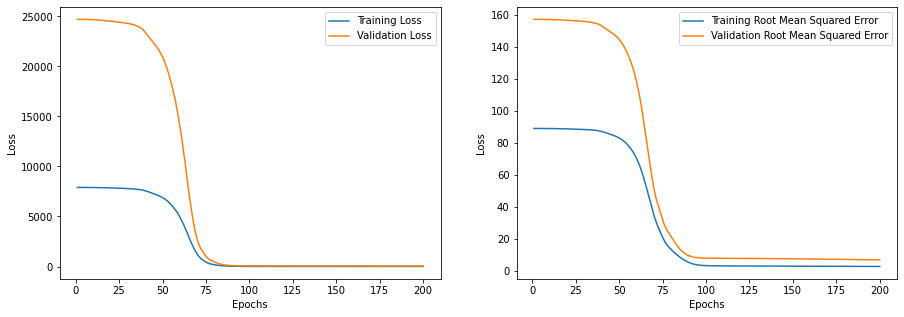

In [75]:
fig, (ax1, ax2) = plt.subplots(1, 2)

fig.set_figheight(5)
fig.set_figwidth(15)

ax1.plot(epochs, loss, label = 'Training Loss')
ax1.plot(epochs, val_loss, label = 'Validation Loss')
ax1.set(xlabel = "Epochs", ylabel = "Loss")
ax1.legend()

ax2.plot(epochs, root_mean_squared_error, label = "Training Root Mean Squared Error")
ax2.plot(epochs, val_root_mean_squared_error, label = "Validation Root Mean Squared Error")
ax2.set(xlabel = "Epochs", ylabel = "Loss")
ax2.legend()

plt.show()

### Prediction

In [76]:
prediction = model.predict(X_test)

5/5 [==============================] - 0s 7ms/step


In [77]:
len(prediction.reshape(-1))

695

In [78]:
temp1 = test.tail(695)

In [79]:
temp1['Forecast'] = prediction.reshape(-1)

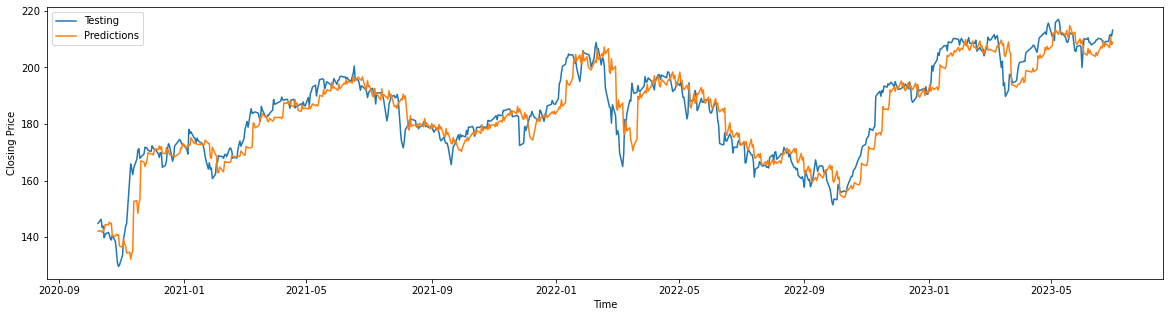

In [80]:
plt.figure(figsize=(20, 5))
plt.plot(temp1['Close'], label = 'Testing')
plt.plot(temp1['Forecast'], label = 'Predictions')
plt.xlabel('Time')
plt.ylabel('Closing Price')
plt.legend(loc = 'best')

In [81]:
rmse = math.sqrt(mean_squared_error(y_test.reshape(-1, 5), prediction))
mape = np.mean(np.abs(prediction - y_test.reshape(-1, 5))/np.abs(y_test.reshape(-1, 5)))
print(f'RMSE: {rmse}')
print(f'MAPE: {mape}')

RMSE: 5.560204275581307
MAPE: 0.0214335438748143


In [82]:
temp1

,Close,pe-ratio,Forecast
Date,,,
2020-10-09,144.838226,9.953418,142.069046
2020-10-12,146.302643,9.953418,142.224548
2020-10-13,143.442734,9.953418,141.632248
2020-10-14,143.873459,9.953418,142.051453
2020-10-15,139.755890,9.953418,142.683029
...,...,...,...
2023-06-26,209.199997,10.264393,207.506317
2023-06-27,211.300003,10.264393,206.962631
2023-06-28,211.649994,10.264393,210.701828


In [83]:
# Extract actual data from SIE
tem1 = ALV['Close'].tolist()[:len(ALV)-695]
# Extract forecasted date from above result
tem2 = temp1['Forecast'].tolist()
# Combine them to a list
tem3 = tem1 + tem2
# Create a column from the resulted list
result1['ALV'] = tem3

In [84]:
result1

,SIE,Forecasted,DTE,ALV
Date,,,,
2010-01-04,39.892437,N,4.953136,45.519119
2010-01-05,39.916805,N,4.911083,45.657921
2010-01-06,40.063042,N,4.789590,46.012665
2010-01-07,40.538315,N,4.698472,45.483131
2010-01-08,40.794235,N,4.724171,45.236355
...,...,...,...,...
2023-06-26,161.531769,Y,38.137283,207.506317
2023-06-27,158.733322,Y,40.614021,206.962631
2023-06-28,168.029846,Y,40.979473,210.701828


## 1.4. MRK

In [85]:
MRK

,Open,High,Low,Close,Volume,Dividends,Stock Splits,pe-ratio,ps-ratio,pb-ratio,Ticker
Date,,,,,,,,,,,
2010-01-04,26.572763,26.780618,26.438271,26.576839,752504.0,0.0,0.0,38.785717,NaN,1.488928,merck-kgaa
2010-01-05,26.527932,26.560537,26.238566,26.381214,488178.0,0.0,0.0,38.785717,NaN,1.488928,merck-kgaa
2010-01-06,26.409742,26.576839,26.140752,26.364910,511138.0,0.0,0.0,38.785717,NaN,1.488928,merck-kgaa
2010-01-07,26.324151,26.972169,26.324151,26.919188,1088580.0,0.0,0.0,38.785717,NaN,1.488928,merck-kgaa
2010-01-08,26.919186,27.053678,26.328226,26.646120,730274.0,0.0,0.0,38.785717,NaN,1.488928,merck-kgaa
...,...,...,...,...,...,...,...,...,...,...,...
2023-06-26,153.000000,154.399994,152.000000,152.600006,255508.0,0.0,0.0,23.026846,3.467976,3.013593,merck-kgaa
2023-06-27,152.250000,152.600006,147.199997,147.199997,603984.0,0.0,0.0,23.026846,3.467976,3.013593,merck-kgaa
2023-06-28,147.550003,150.699997,147.350006,150.500000,419786.0,0.0,0.0,23.026846,3.467976,3.013593,merck-kgaa


In [86]:
MRK.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3449 entries, 2010-01-04 to 2023-06-30
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Open          3449 non-null   float64
 1   High          3449 non-null   float64
 2   Low           3449 non-null   float64
 3   Close         3449 non-null   float64
 4   Volume        3449 non-null   float64
 5   Dividends     3449 non-null   float64
 6   Stock Splits  3449 non-null   float64
 7   pe-ratio      3449 non-null   float64
 8   ps-ratio      3387 non-null   float64
 9   pb-ratio      3449 non-null   float64
 10  Ticker        3449 non-null   object 
dtypes: float64(10), object(1)
memory usage: 323.3+ KB


In [87]:
MRK_df1 = MRK[["Close", "pe-ratio"]]
MRK_df1

,Close,pe-ratio
Date,,
2010-01-04,26.576839,38.785717
2010-01-05,26.381214,38.785717
2010-01-06,26.364910,38.785717
2010-01-07,26.919188,38.785717
2010-01-08,26.646120,38.785717
...,...,...
2023-06-26,152.600006,23.026846
2023-06-27,147.199997,23.026846
2023-06-28,150.500000,23.026846


### Data Proprocessing

In [88]:
# Split data to train set and test set
train, test = split(MRK_df1, end_date, test_start_date)

In [89]:
# Reconcile length of data set and subsets
MRK_df1.shape[0] == train.shape[0] + test.shape[0]

True

In [90]:
# Process data
X_train, y_train = Dataset(train, 2)
X_test, y_test = Dataset(test, 2)

In [91]:
# Split train set to train set and validation set
X_train, X_val = split_val(X_train, 0.8)
y_train, y_val = split_val(y_train, 0.8)

### Model

In [92]:
# Define model (Mehtab et al., 2021)
def Model():
    model = tf.keras.models.Sequential([
                                      tf.keras.layers.LSTM(200, input_shape = (5, 2), activation = tf.nn.leaky_relu, return_sequences = True),
                                      tf.keras.layers.LSTM(200, activation = tf.nn.leaky_relu, return_sequences = True),
                                      tf.keras.layers.LSTM(200, activation = tf.nn.leaky_relu),
                                      tf.keras.layers.Dense(300, activation = tf.nn.leaky_relu),
                                      tf.keras.layers.Dense(200, activation = tf.nn.leaky_relu),
                                      tf.keras.layers.Dense(100, activation = tf.nn.leaky_relu),
                                      tf.keras.layers.Dense(50, activation = tf.nn.leaky_relu),
                                      tf.keras.layers.Dense(5, activation = tf.nn.leaky_relu)
                                      ])
    return model

In [93]:
model = Model()

In [94]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_7 (LSTM)               (None, 5, 200)            162400    
                                                                 
 lstm_8 (LSTM)               (None, 5, 200)            320800    
                                                                 
 lstm_9 (LSTM)               (None, 200)               320800    
                                                                 
 dense_13 (Dense)            (None, 300)               60300     
                                                                 
 dense_14 (Dense)            (None, 200)               60200     
                                                                 
 dense_15 (Dense)            (None, 100)               20100     
                                                                 
 dense_16 (Dense)            (None, 50)               

### Custom Learning Rate

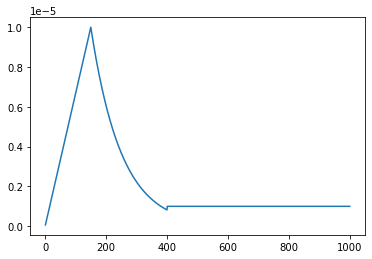

In [95]:
epochs = [i for i in range(1, 1001, 1)]
lrate = [scheduler(i) for i in range(1, 1001, 1)]
plt.plot(epochs, lrate)

In [96]:
callback = tf.keras.callbacks.LearningRateScheduler(scheduler)

### Learning

In [97]:
# Compile model (Mehtab et al., 2021)
model.compile(optimizer = tf.keras.optimizers.Adam(), loss = 'mse', metrics = tf.keras.metrics.RootMeanSquaredError())

In [98]:
# Fit model (Mehtab et al., 2021)
hist = model.fit(X_train, y_train, epochs = 200, validation_data = (X_val, y_val), callbacks=[callback])

Epoch 1/200
14/14 [==============================] - 6s 84ms/step - loss: 3934.0083 - root_mean_squared_error: 62.7217 - val_loss: 9039.2178 - val_root_mean_squared_error: 95.0748 - lr: 0.0000e+00
Epoch 2/200
14/14 [==============================] - 1s 37ms/step - loss: 3933.9824 - root_mean_squared_error: 62.7215 - val_loss: 9039.0684 - val_root_mean_squared_error: 95.0740 - lr: 6.6667e-08
Epoch 3/200
14/14 [==============================] - 1s 42ms/step - loss: 3933.9001 - root_mean_squared_error: 62.7208 - val_loss: 9038.7695 - val_root_mean_squared_error: 95.0724 - lr: 1.3333e-07
Epoch 4/200
14/14 [==============================] - 1s 40ms/step - loss: 3933.7585 - root_mean_squared_error: 62.7197 - val_loss: 9038.3252 - val_root_mean_squared_error: 95.0701 - lr: 2.0000e-07
Epoch 5/200
14/14 [==============================] - 1s 42ms/step - loss: 3933.5581 - root_mean_squared_error: 62.7181 - val_loss: 9037.7314 - val_root_mean_squared_error: 95.0670 - lr: 2.6667e-07
Epoch 6/200
14/

Epoch 84/200
14/14 [==============================] - 1s 40ms/step - loss: 14.4735 - root_mean_squared_error: 3.8044 - val_loss: 33.3745 - val_root_mean_squared_error: 5.7771 - lr: 5.5333e-06
Epoch 85/200
14/14 [==============================] - 1s 38ms/step - loss: 13.4589 - root_mean_squared_error: 3.6686 - val_loss: 31.6426 - val_root_mean_squared_error: 5.6252 - lr: 5.6000e-06
Epoch 86/200
14/14 [==============================] - 0s 26ms/step - loss: 12.6115 - root_mean_squared_error: 3.5513 - val_loss: 29.7830 - val_root_mean_squared_error: 5.4574 - lr: 5.6667e-06
Epoch 87/200
14/14 [==============================] - 0s 34ms/step - loss: 11.8045 - root_mean_squared_error: 3.4358 - val_loss: 27.6145 - val_root_mean_squared_error: 5.2549 - lr: 5.7333e-06
Epoch 88/200
14/14 [==============================] - 1s 39ms/step - loss: 11.0554 - root_mean_squared_error: 3.3250 - val_loss: 25.3168 - val_root_mean_squared_error: 5.0316 - lr: 5.8000e-06
Epoch 89/200
14/14 [====================

Epoch 127/200
14/14 [==============================] - 1s 41ms/step - loss: 4.5372 - root_mean_squared_error: 2.1301 - val_loss: 15.9537 - val_root_mean_squared_error: 3.9942 - lr: 8.4000e-06
Epoch 128/200
14/14 [==============================] - 1s 43ms/step - loss: 4.5517 - root_mean_squared_error: 2.1335 - val_loss: 15.3049 - val_root_mean_squared_error: 3.9121 - lr: 8.4667e-06
Epoch 129/200
14/14 [==============================] - 1s 43ms/step - loss: 4.5450 - root_mean_squared_error: 2.1319 - val_loss: 15.2522 - val_root_mean_squared_error: 3.9054 - lr: 8.5333e-06
Epoch 130/200
14/14 [==============================] - 1s 42ms/step - loss: 4.5398 - root_mean_squared_error: 2.1307 - val_loss: 15.5525 - val_root_mean_squared_error: 3.9437 - lr: 8.6000e-06
Epoch 131/200
14/14 [==============================] - 1s 43ms/step - loss: 4.5180 - root_mean_squared_error: 2.1256 - val_loss: 14.9477 - val_root_mean_squared_error: 3.8662 - lr: 8.6667e-06
Epoch 132/200
14/14 [===================

Epoch 170/200
14/14 [==============================] - 1s 44ms/step - loss: 4.1096 - root_mean_squared_error: 2.0272 - val_loss: 14.2617 - val_root_mean_squared_error: 3.7765 - lr: 8.2696e-06
Epoch 171/200
14/14 [==============================] - 1s 39ms/step - loss: 4.0533 - root_mean_squared_error: 2.0133 - val_loss: 14.5221 - val_root_mean_squared_error: 3.8108 - lr: 8.1873e-06
Epoch 172/200
14/14 [==============================] - 1s 41ms/step - loss: 3.9713 - root_mean_squared_error: 1.9928 - val_loss: 13.6966 - val_root_mean_squared_error: 3.7009 - lr: 8.1058e-06
Epoch 173/200
14/14 [==============================] - 1s 41ms/step - loss: 4.0110 - root_mean_squared_error: 2.0027 - val_loss: 13.8303 - val_root_mean_squared_error: 3.7189 - lr: 8.0252e-06
Epoch 174/200
14/14 [==============================] - 0s 35ms/step - loss: 4.0221 - root_mean_squared_error: 2.0055 - val_loss: 14.3321 - val_root_mean_squared_error: 3.7858 - lr: 7.9453e-06
Epoch 175/200
14/14 [===================

In [99]:
history_dict = hist.history

loss = history_dict["loss"]
root_mean_squared_error = history_dict["root_mean_squared_error"]
val_loss = history_dict["val_loss"]
val_root_mean_squared_error = history_dict["val_root_mean_squared_error"]

epochs = range(1, len(loss) + 1)

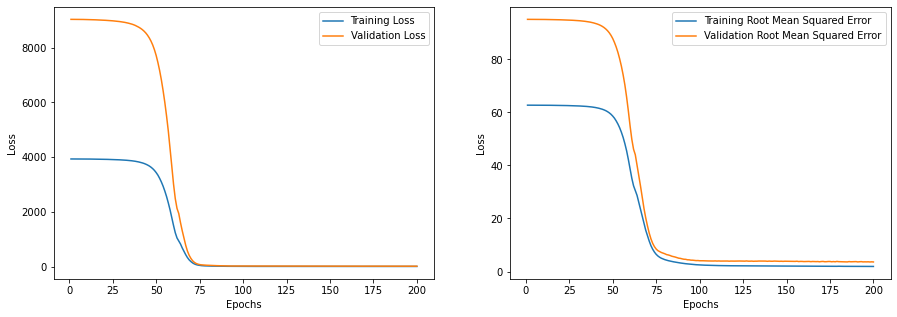

In [100]:
fig, (ax1, ax2) = plt.subplots(1, 2)

fig.set_figheight(5)
fig.set_figwidth(15)

ax1.plot(epochs, loss, label = 'Training Loss')
ax1.plot(epochs, val_loss, label = 'Validation Loss')
ax1.set(xlabel = "Epochs", ylabel = "Loss")
ax1.legend()

ax2.plot(epochs, root_mean_squared_error, label = "Training Root Mean Squared Error")
ax2.plot(epochs, val_root_mean_squared_error, label = "Validation Root Mean Squared Error")
ax2.set(xlabel = "Epochs", ylabel = "Loss")
ax2.legend()

plt.show()

### Prediction

In [101]:
prediction = model.predict(X_test)

5/5 [==============================] - 1s 9ms/step


In [102]:
len(prediction.reshape(-1))

695

In [103]:
temp1 = test.tail(695)

In [104]:
temp1['Forecast'] = prediction.reshape(-1)

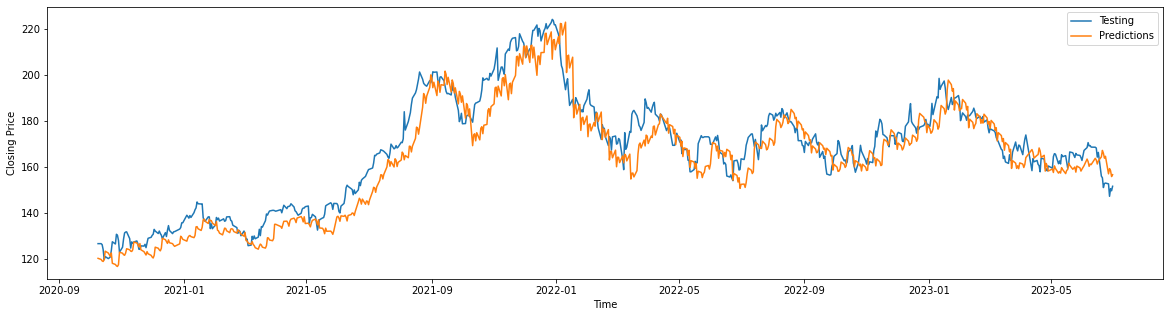

In [105]:
plt.figure(figsize=(20, 5))
plt.plot(temp1['Close'], label = 'Testing')
plt.plot(temp1['Forecast'], label = 'Predictions')
plt.xlabel('Time')
plt.ylabel('Closing Price')
plt.legend(loc = 'best')

In [106]:
rmse = math.sqrt(mean_squared_error(y_test.reshape(-1, 5), prediction))
mape = np.mean(np.abs(prediction - y_test.reshape(-1, 5))/np.abs(y_test.reshape(-1, 5)))
print(f'RMSE: {rmse}')
print(f'MAPE: {mape}')

RMSE: 8.085180894059702
MAPE: 0.038392776508482385


In [107]:
temp1

,Close,pe-ratio,Forecast
Date,,,
2020-10-09,126.661209,28.965117,120.284950
2020-10-12,126.661209,28.965117,119.802170
2020-10-13,126.226120,28.965117,119.165428
2020-10-14,124.098984,28.965117,118.930122
2020-10-15,119.699684,28.965117,119.754181
...,...,...,...
2023-06-26,152.600006,23.026846,156.953033
2023-06-27,147.199997,23.026846,159.226746
2023-06-28,150.500000,23.026846,158.331451


In [108]:
# Extract actual data from SIE
tem1 = MRK['Close'].tolist()[:len(MRK)-695]
# Extract forecasted date from above result
tem2 = temp1['Forecast'].tolist()
# Combine them to a list
tem3 = tem1 + tem2
# Create a column from the resulted list
result1['MRK'] = tem3

In [109]:
result1

,SIE,Forecasted,DTE,ALV,MRK
Date,,,,,
2010-01-04,39.892437,N,4.953136,45.519119,26.576839
2010-01-05,39.916805,N,4.911083,45.657921,26.381214
2010-01-06,40.063042,N,4.789590,46.012665,26.364910
2010-01-07,40.538315,N,4.698472,45.483131,26.919188
2010-01-08,40.794235,N,4.724171,45.236355,26.646120
...,...,...,...,...,...
2023-06-26,161.531769,Y,38.137283,207.506317,156.953033
2023-06-27,158.733322,Y,40.614021,206.962631,159.226746
2023-06-28,168.029846,Y,40.979473,210.701828,158.331451


## 1.5. DHL

In [110]:
DHL

,Open,High,Low,Close,Volume,Dividends,Stock Splits,pe-ratio,ps-ratio,pb-ratio,Ticker
Date,,,,,,,,,,,
2010-01-04,13.550000,13.980000,13.550000,13.980,3020790.0,0.0,0.0,25.443396,NaN,1.970697,deutsche-post
2010-01-05,13.935000,14.135000,13.830000,14.000,2735783.0,0.0,0.0,25.443396,NaN,1.970697,deutsche-post
2010-01-06,13.980000,14.230000,13.925000,14.155,2595800.0,0.0,0.0,25.443396,NaN,1.970697,deutsche-post
2010-01-07,14.110000,14.195000,14.020000,14.125,2907679.0,0.0,0.0,25.443396,NaN,1.970697,deutsche-post
2010-01-08,14.140000,14.525000,14.060000,14.460,5462896.0,0.0,0.0,25.443396,NaN,1.970697,deutsche-post
...,...,...,...,...,...,...,...,...,...,...,...
2023-06-26,43.435001,43.514999,42.619999,43.000,1812008.0,0.0,0.0,10.613300,0.578296,1.588590,deutsche-post
2023-06-27,43.314999,43.590000,43.174999,43.500,2197942.0,0.0,0.0,10.613300,0.578296,1.588590,deutsche-post
2023-06-28,43.709999,44.415001,43.645000,44.305,1739606.0,0.0,0.0,10.613300,0.578296,1.588590,deutsche-post


In [111]:
DHL.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3441 entries, 2010-01-04 to 2023-06-30
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Open          3441 non-null   float64
 1   High          3441 non-null   float64
 2   Low           3441 non-null   float64
 3   Close         3441 non-null   float64
 4   Volume        3441 non-null   float64
 5   Dividends     3441 non-null   float64
 6   Stock Splits  3441 non-null   float64
 7   pe-ratio      3441 non-null   float64
 8   ps-ratio      3379 non-null   float64
 9   pb-ratio      3441 non-null   float64
 10  Ticker        3441 non-null   object 
dtypes: float64(10), object(1)
memory usage: 322.6+ KB


In [112]:
DHL_df1 = DHL[["Close", "pe-ratio"]]
DHL_df1

,Close,pe-ratio
Date,,
2010-01-04,13.980,25.443396
2010-01-05,14.000,25.443396
2010-01-06,14.155,25.443396
2010-01-07,14.125,25.443396
2010-01-08,14.460,25.443396
...,...,...
2023-06-26,43.000,10.613300
2023-06-27,43.500,10.613300
2023-06-28,44.305,10.613300


### Data Proprocessing

In [113]:
# Split data to train set and test set
train, test = split(DHL_df1, end_date, test_start_date)

In [114]:
# Reconcile length of data set and subsets
DHL_df1.shape[0] == train.shape[0] + test.shape[0]

True

In [115]:
# Process data
X_train, y_train = Dataset(train, 2)
X_test, y_test = Dataset(test, 2)

In [116]:
# Split train set to train set and validation set
X_train, X_val = split_val(X_train, 0.8)
y_train, y_val = split_val(y_train, 0.8)

### Model

In [117]:
# Define model (Mehtab et al., 2021)
def Model():
    model = tf.keras.models.Sequential([
                                      tf.keras.layers.LSTM(200, input_shape = (5, 2), activation = tf.nn.leaky_relu, return_sequences = True),
                                      tf.keras.layers.LSTM(200, activation = tf.nn.leaky_relu),
                                      tf.keras.layers.Dense(200, activation = tf.nn.leaky_relu),
                                      tf.keras.layers.Dense(100, activation = tf.nn.leaky_relu),
                                      tf.keras.layers.Dense(50, activation = tf.nn.leaky_relu),
                                      tf.keras.layers.Dense(5, activation = tf.nn.leaky_relu)
                                      ])
    return model

In [118]:
model = Model()

In [119]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_10 (LSTM)              (None, 5, 200)            162400    
                                                                 
 lstm_11 (LSTM)              (None, 200)               320800    
                                                                 
 dense_18 (Dense)            (None, 200)               40200     
                                                                 
 dense_19 (Dense)            (None, 100)               20100     
                                                                 
 dense_20 (Dense)            (None, 50)                5050      
                                                                 
 dense_21 (Dense)            (None, 5)                 255       
                                                                 
Total params: 548,805
Trainable params: 548,805
Non-tr

### Custom Learning Rate

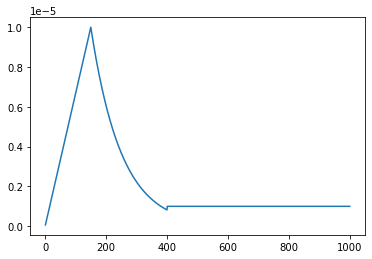

In [120]:
epochs = [i for i in range(1, 1001, 1)]
lrate = [scheduler(i) for i in range(1, 1001, 1)]
plt.plot(epochs, lrate)

In [121]:
callback = tf.keras.callbacks.LearningRateScheduler(scheduler)

### Learning

In [122]:
# Compile model (Mehtab et al., 2021)
model.compile(optimizer = tf.keras.optimizers.Adam(), loss = 'mse', metrics = tf.keras.metrics.RootMeanSquaredError())

In [123]:
# Fit model (Mehtab et al., 2021)
hist = model.fit(X_train, y_train, epochs = 200, validation_data = (X_val, y_val), callbacks=[callback])

Epoch 1/200
14/14 [==============================] - 5s 65ms/step - loss: 576.0362 - root_mean_squared_error: 24.0008 - val_loss: 913.9861 - val_root_mean_squared_error: 30.2322 - lr: 0.0000e+00
Epoch 2/200
14/14 [==============================] - 0s 32ms/step - loss: 576.0297 - root_mean_squared_error: 24.0006 - val_loss: 913.9626 - val_root_mean_squared_error: 30.2318 - lr: 6.6667e-08
Epoch 3/200
14/14 [==============================] - 1s 36ms/step - loss: 576.0083 - root_mean_squared_error: 24.0002 - val_loss: 913.9161 - val_root_mean_squared_error: 30.2310 - lr: 1.3333e-07
Epoch 4/200
14/14 [==============================] - 0s 32ms/step - loss: 575.9724 - root_mean_squared_error: 23.9994 - val_loss: 913.8450 - val_root_mean_squared_error: 30.2299 - lr: 2.0000e-07
Epoch 5/200
14/14 [==============================] - 0s 32ms/step - loss: 575.9205 - root_mean_squared_error: 23.9983 - val_loss: 913.7507 - val_root_mean_squared_error: 30.2283 - lr: 2.6667e-07
Epoch 6/200
14/14 [======

Epoch 43/200
14/14 [==============================] - 1s 33ms/step - loss: 545.6797 - root_mean_squared_error: 23.3598 - val_loss: 861.5769 - val_root_mean_squared_error: 29.3526 - lr: 2.8000e-06
Epoch 44/200
14/14 [==============================] - 0s 34ms/step - loss: 542.2152 - root_mean_squared_error: 23.2855 - val_loss: 855.5574 - val_root_mean_squared_error: 29.2499 - lr: 2.8667e-06
Epoch 45/200
14/14 [==============================] - 0s 30ms/step - loss: 538.3832 - root_mean_squared_error: 23.2031 - val_loss: 848.9818 - val_root_mean_squared_error: 29.1373 - lr: 2.9333e-06
Epoch 46/200
14/14 [==============================] - 0s 29ms/step - loss: 534.1813 - root_mean_squared_error: 23.1124 - val_loss: 841.6810 - val_root_mean_squared_error: 29.0117 - lr: 3.0000e-06
Epoch 47/200
14/14 [==============================] - 0s 32ms/step - loss: 529.6259 - root_mean_squared_error: 23.0136 - val_loss: 833.4831 - val_root_mean_squared_error: 28.8701 - lr: 3.0667e-06
Epoch 48/200
14/14 [

Epoch 128/200
14/14 [==============================] - 0s 32ms/step - loss: 3.0204 - root_mean_squared_error: 1.7379 - val_loss: 2.0457 - val_root_mean_squared_error: 1.4303 - lr: 8.4667e-06
Epoch 129/200
14/14 [==============================] - 0s 33ms/step - loss: 2.8482 - root_mean_squared_error: 1.6877 - val_loss: 2.0039 - val_root_mean_squared_error: 1.4156 - lr: 8.5333e-06
Epoch 130/200
14/14 [==============================] - 1s 33ms/step - loss: 2.6852 - root_mean_squared_error: 1.6387 - val_loss: 1.9697 - val_root_mean_squared_error: 1.4035 - lr: 8.6000e-06
Epoch 131/200
14/14 [==============================] - 0s 32ms/step - loss: 2.5262 - root_mean_squared_error: 1.5894 - val_loss: 1.9308 - val_root_mean_squared_error: 1.3895 - lr: 8.6667e-06
Epoch 132/200
14/14 [==============================] - 0s 31ms/step - loss: 2.3850 - root_mean_squared_error: 1.5443 - val_loss: 1.8928 - val_root_mean_squared_error: 1.3758 - lr: 8.7333e-06
Epoch 133/200
14/14 [========================

Epoch 171/200
14/14 [==============================] - 0s 30ms/step - loss: 0.7794 - root_mean_squared_error: 0.8828 - val_loss: 1.5454 - val_root_mean_squared_error: 1.2431 - lr: 8.1873e-06
Epoch 172/200
14/14 [==============================] - 0s 33ms/step - loss: 0.7709 - root_mean_squared_error: 0.8780 - val_loss: 1.5446 - val_root_mean_squared_error: 1.2428 - lr: 8.1058e-06
Epoch 173/200
14/14 [==============================] - 1s 46ms/step - loss: 0.7635 - root_mean_squared_error: 0.8738 - val_loss: 1.5435 - val_root_mean_squared_error: 1.2424 - lr: 8.0252e-06
Epoch 174/200
14/14 [==============================] - 0s 31ms/step - loss: 0.7599 - root_mean_squared_error: 0.8717 - val_loss: 1.5380 - val_root_mean_squared_error: 1.2402 - lr: 7.9453e-06
Epoch 175/200
14/14 [==============================] - 0s 31ms/step - loss: 0.7512 - root_mean_squared_error: 0.8667 - val_loss: 1.5324 - val_root_mean_squared_error: 1.2379 - lr: 7.8663e-06
Epoch 176/200
14/14 [========================

In [124]:
history_dict = hist.history

loss = history_dict["loss"]
root_mean_squared_error = history_dict["root_mean_squared_error"]
val_loss = history_dict["val_loss"]
val_root_mean_squared_error = history_dict["val_root_mean_squared_error"]

epochs = range(1, len(loss) + 1)

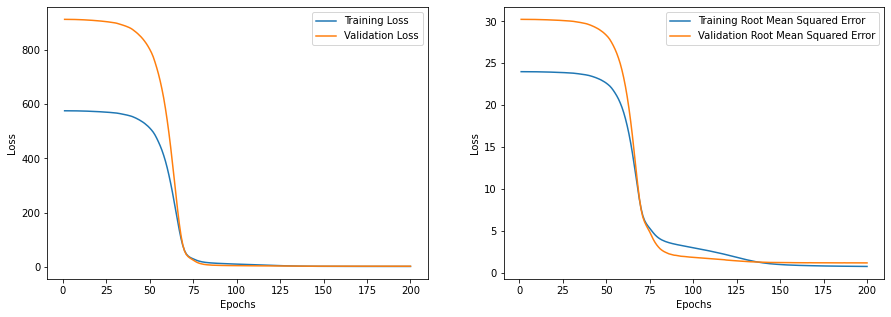

In [125]:
fig, (ax1, ax2) = plt.subplots(1, 2)

fig.set_figheight(5)
fig.set_figwidth(15)

ax1.plot(epochs, loss, label = 'Training Loss')
ax1.plot(epochs, val_loss, label = 'Validation Loss')
ax1.set(xlabel = "Epochs", ylabel = "Loss")
ax1.legend()

ax2.plot(epochs, root_mean_squared_error, label = "Training Root Mean Squared Error")
ax2.plot(epochs, val_root_mean_squared_error, label = "Validation Root Mean Squared Error")
ax2.set(xlabel = "Epochs", ylabel = "Loss")
ax2.legend()

plt.show()

### Prediction

In [126]:
prediction = model.predict(X_test)

5/5 [==============================] - 0s 12ms/step


In [127]:
len(prediction.reshape(-1))

695

In [128]:
temp1 = test.tail(695)

In [129]:
temp1['Forecast'] = prediction.reshape(-1)

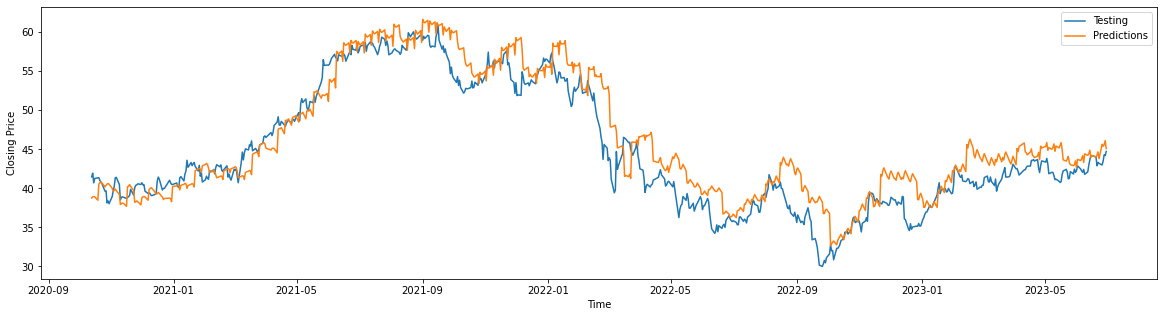

In [130]:
plt.figure(figsize=(20, 5))
plt.plot(temp1['Close'], label = 'Testing')
plt.plot(temp1['Forecast'], label = 'Predictions')
plt.xlabel('Time')
plt.ylabel('Closing Price')
plt.legend(loc = 'best')

In [131]:
rmse = math.sqrt(mean_squared_error(y_test.reshape(-1, 5), prediction))
mape = np.mean(np.abs(prediction - y_test.reshape(-1, 5))/np.abs(y_test.reshape(-1, 5)))
print(f'RMSE: {rmse}')
print(f'MAPE: {mape}')

RMSE: 2.6126037793745125
MAPE: 0.049500026241525476


In [132]:
temp1

,Close,pe-ratio,Forecast
Date,,,
2020-10-13,41.470001,18.933283,38.771660
2020-10-14,41.950001,18.933283,38.910854
2020-10-15,40.709999,18.933283,38.949524
2020-10-16,41.270000,18.933283,38.908836
2020-10-19,41.340000,18.933283,38.485916
...,...,...,...
2023-06-26,43.000000,10.613300,45.643761
2023-06-27,43.500000,10.613300,45.401493
2023-06-28,44.305000,10.613300,45.604198


In [133]:
# Extract actual data from SIE
tem1 = DHL['Close'].tolist()[:len(DHL)+8-695]
# Extract forecasted date from above result
tem2 = temp1['Forecast'].tolist()
# Combine them to a list
tem3 = tem1 + tem2
# Create a column from the resulted list
result1['DHL'] = tem3

In [134]:
result1

,SIE,Forecasted,DTE,ALV,MRK,DHL
Date,,,,,,
2010-01-04,39.892437,N,4.953136,45.519119,26.576839,13.980000
2010-01-05,39.916805,N,4.911083,45.657921,26.381214,14.000000
2010-01-06,40.063042,N,4.789590,46.012665,26.364910,14.155000
2010-01-07,40.538315,N,4.698472,45.483131,26.919188,14.125000
2010-01-08,40.794235,N,4.724171,45.236355,26.646120,14.460000
...,...,...,...,...,...,...
2023-06-26,161.531769,Y,38.137283,207.506317,156.953033,45.643761
2023-06-27,158.733322,Y,40.614021,206.962631,159.226746,45.401493
2023-06-28,168.029846,Y,40.979473,210.701828,158.331451,45.604198


In [135]:
# Define the desired column order
desired_order = ['SIE', 'DTE', 'ALV', 'MRK', 'DHL', 'Forecasted']

# Rearrange columns
result = result1[desired_order]
result

,SIE,DTE,ALV,MRK,DHL,Forecasted
Date,,,,,,
2010-01-04,39.892437,4.953136,45.519119,26.576839,13.980000,N
2010-01-05,39.916805,4.911083,45.657921,26.381214,14.000000,N
2010-01-06,40.063042,4.789590,46.012665,26.364910,14.155000,N
2010-01-07,40.538315,4.698472,45.483131,26.919188,14.125000,N
2010-01-08,40.794235,4.724171,45.236355,26.646120,14.460000,N
...,...,...,...,...,...,...
2023-06-26,161.531769,38.137283,207.506317,156.953033,45.643761,Y
2023-06-27,158.733322,40.614021,206.962631,159.226746,45.401493,Y
2023-06-28,168.029846,40.979473,210.701828,158.331451,45.604198,Y


In [136]:
result.to_csv('LSTM_2 feature.csv', index=True)

# Bibliography

- Mehtab, S., Sen, J., & Dutta, A. (2021). Stock price prediction using machine learning and LSTM-based deep learning models. In _Machine Learning and Metaheuristics Algorithms, and Applications: Second Symposium, SoMMA 2020, Chennai, India, October 14–17, 2020, Revised Selected Papers 2_ (pp. 88-106). Springer Singapore.